In [15]:
# Extracting the Images
#from shutil import unpack_archive
#unpack_archive('87153_200743_bundle_archive.zip', 'D:/DS/Mala_Deep_Transfer/')

In [1]:
import os
print(os.listdir("D:/DS/Mala_Deep_Transfer/"))
print(os.listdir("D:/DS/Mala_Deep_Transfer/cell_images"))


['cell_images']
['cell_images', 'Parasitized', 'Uninfected']


C59P20thinF_IMG_20150803_111333_cell_143.png
C131P92ThinF_IMG_20151004_145224_cell_138.png
C118P79ThinF_IMG_20151002_110609_cell_2.png
C48P9thinF_IMG_20150721_160944_cell_208.png
C179P140ThinF_IMG_20151127_153436_cell_167.png


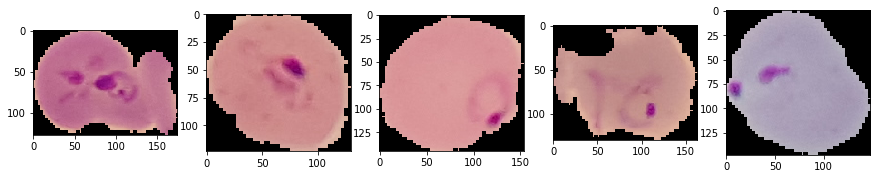

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow,imread
import random
para_img = os.listdir("D:/DS/Mala_Deep_Transfer/cell_images/Parasitized")
rand_img = random.sample(para_img,5)
plt.figure(1,figsize=(15,9))
for i,img in enumerate(rand_img):
    plt.subplot(1,5,i+1)
    print(img)
    plt.imshow(imread("D:/DS/Mala_Deep_Transfer/cell_images/Parasitized/"+img))
plt.show()

C215ThinF_IMG_20151106_133043_cell_202.png
C150P111ThinF_IMG_20151115_115805_cell_163.png
C163P124ThinF_IMG_20151116_110818_cell_186.png
C220ThinF_IMG_20151106_154016_cell_44.png
C219ThinF_IMG_20151106_150314_cell_15.png


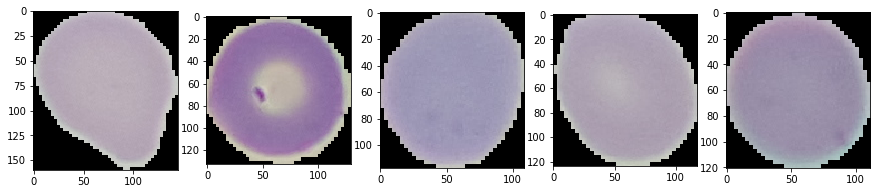

In [4]:
un_img = os.listdir("D:/DS/Mala_Deep_Transfer/cell_images/Uninfected")
rand_img = random.sample(un_img,5)
plt.figure(1,figsize=(15,9))
for i,img in enumerate(rand_img):
    plt.subplot(1,5,i+1)
    print(img)
    plt.imshow(imread("D:/DS/Mala_Deep_Transfer/cell_images/Uninfected/"+img))
plt.show()


In [5]:
# Resize the image into 112*112
from skimage.transform import resize
data = []
rand_para = random.sample(para_img,3000)
for i,img in enumerate(rand_para):
    try :
        temp = resize(imread("D:/DS/Mala_Deep_Transfer/cell_images/Parasitized/"+img),(112,112))
    except :
        continue
    data.append(temp) 

In [7]:
# Assign the Length of Para
para_len = len(data)

In [8]:
# for Uninfected
rand_un = random.sample(un_img,3000)
for i,img in enumerate(rand_un):
    try :
        temp = resize(imread("D:/DS/Mala_Deep_Transfer/cell_images/Uninfected/"+img),(112,112))
    except :
        continue
    data.append(temp)

In [9]:
len(data)

6000

In [10]:
# Assigin the Label
label_1 = [1 for i in range(para_len)]
label_0 = [0 for i in range(len(data)-para_len)]
label = label_1+label_0

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(np.array(data),np.array(label),test_size=0.20,random_state = 12,shuffle=True)

In [12]:
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout,Add,Input,Lambda,Concatenate,Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import VGG16,Xception,ResNet50,MobileNetV2,InceptionV3,VGG19,DenseNet121

Using TensorFlow backend.


In [13]:
input_imgs  = Input((112,112,3))
base = ResNet50(include_top=False, input_shape=(112,112,3), pooling='max')
base.layers.pop()
base.layers[-1].outbound_nodes = []
base.outputs = [base.layers[-1].output]
base_last = base(input_imgs)
conv_last = Conv2D(512,kernel_size=4,name='conv_last')(base_last)
conv_last = Reshape((-1,),name='conv_reshape')(conv_last)
conv_last = Dropout(0.25,name='drop_1')(conv_last)
dense_2 = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01),name='dense_2')(conv_last)
dense_2 = Dropout(0.5,name='drop_2')(dense_2)
output = Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),name='output')(dense_2)
model = Model(inputs=input_imgs,outputs=output,name='CNN Model')


In [14]:
for layer in base.layers[:]:
    layer.trainable = False
    
    if layer.name.startswith('bn'):
        layer.call(layer.input, training=False)
model.summary()

Model: "CNN Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
conv_last (Conv2D)           (None, 1, 1, 512)         16777728  
_________________________________________________________________
conv_reshape (Reshape)       (None, 512)               0         
_________________________________________________________________
drop_1 (Dropout)             (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
drop_2 (Dropout)             (None, 256)               0 

In [ ]:
checkpoint = ModelCheckpoint("D:/DS/Mala_Deep_Transfer/model_res.h5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(train_x,train_y,validation_split=0.05,batch_size=128,callbacks = [checkpoint],epochs=1,verbose=1)

In [18]:
model.evaluate(train_x,train_y)

4800/4800 [==============================] - 503s 105ms/step


[6.537894646326701, 0.49291667342185974]

In [19]:
model.evaluate(test_x,test_y)

1200/1200 [==============================] - 139s 116ms/step


[6.15439089457194, 0.528333306312561]